## VdP Iterative resolution & error propagation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.metrics import mean_squared_error
import os

def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=1000) -> float:
    # Initial z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            R_s = 1 / z_curr
            return R_s

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan


def propagate_vdp_uncertainty_mc(Rf_mean, Rf_sem, Rb_mean, Rb_sem, n_samples=10000) -> tuple:
    
    if np.isnan(Rf_mean) or np.isnan(Rb_mean) or np.isnan(Rf_sem) or np.isnan(Rb_sem):
        return np.nan, np.nan, np.nan
    
    # Generate random samples assuming normal distributions
    Rf_samples = np.random.normal(Rf_mean, Rf_sem, n_samples)
    Rb_samples = np.random.normal(Rb_mean, Rb_sem, n_samples)
    
    # Rs for each sample
    Rs_samples = np.zeros(n_samples)
    for i in range(n_samples):
        Rs_samples[i] = calculate_sheet_resistance_vdp(Rf_samples[i], Rb_samples[i])
    
    # Statistics
    Rs_mean = np.mean(Rs_samples)
    Rs_std = np.std(Rs_samples, ddof=1)
    Rs_sem = Rs_std / np.sqrt(n_samples) 
    
    return Rs_mean, Rs_std, Rs_sem

## Dataline-wise VDP

1. Remove all rows for which $\Delta T_{f-f}, \Delta T_{b-b} > \Delta T_{cutoff}$ PLUS $\Delta T_{f-b} > \Delta T_{inter}$
2. For each row solve Van der Pauw equation, where $T_{VDP} = \frac{T_f + T_b}{2}$

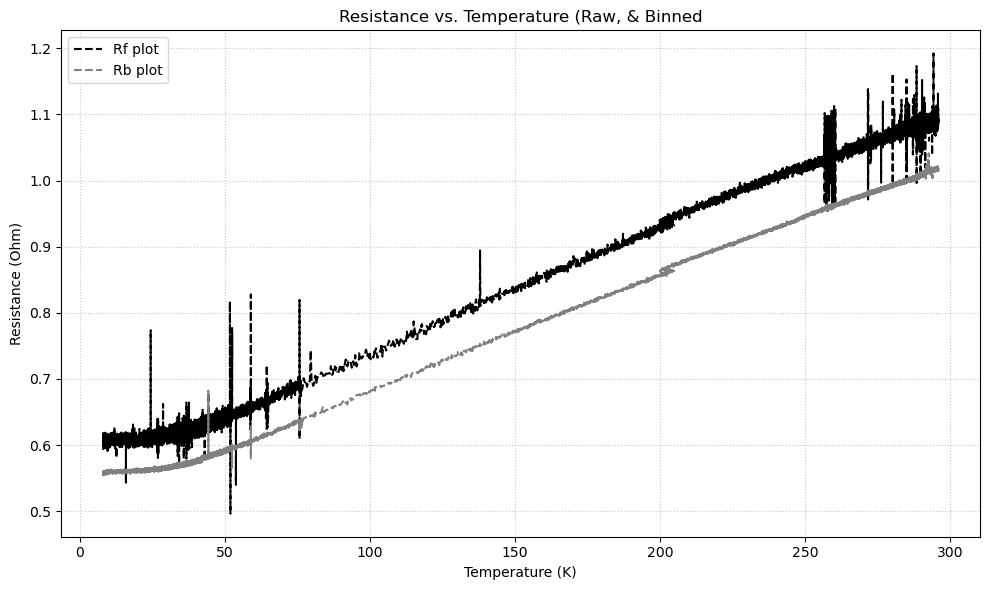

Text(0.5, 1.0, 'Sheet Resistance vs. Temperature')

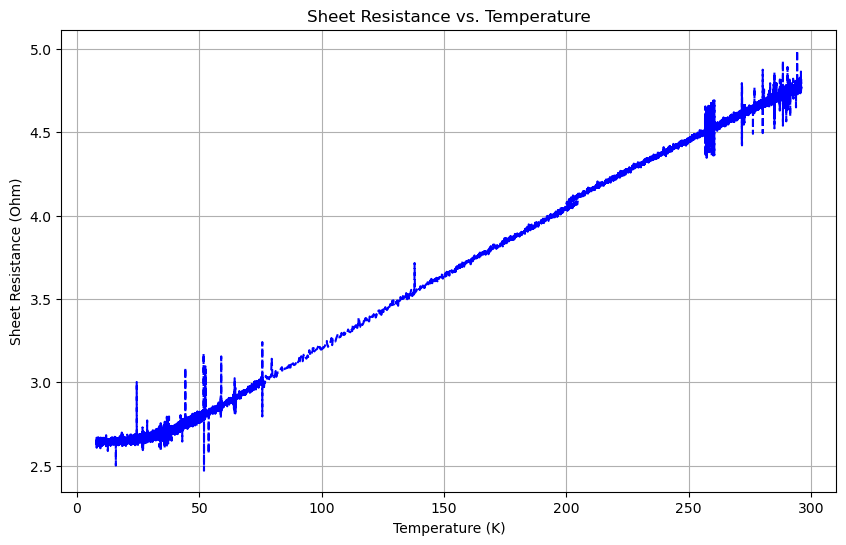

In [3]:
file_path = "DataSets/heating_8_to_296.dat"

# Load the data using pandas.
# sep='\s+' handles one or more spaces as delimiters.
# header=None indicates no header row.
# skipinitialspace=True handles potential leading spaces.
df = pd.read_csv(file_path, sep=r'\s+', header=None, skipinitialspace=True)

# The last row in your data might be incomplete. Remove any rows with NaN values if they appear.
df = df.dropna()

# front_temp (Column 6 -> index 5)
# front_temp_fluct (Column 7 -> index 6)
# front_R (Column 8 -> index 7)
# back_temp (Column 17 -> index 16)
# back_temp_fluct (Column 18 -> index 17)
# back_R (Column 19 -> index 18)

front_temp_raw = df.iloc[:, 5].astype(float)
front_temp_fluct_raw = df.iloc[:, 6].astype(float)
front_R = df.iloc[:, 7].astype(float)

back_temp_raw = df.iloc[:, 16].astype(float)
back_temp_fluct_raw = df.iloc[:, 17].astype(float)
back_R = df.iloc[:, 18].astype(float)

avg_temp = df.iloc[:, 26].astype(float)  


# # ---------------------------------------------
intra_cutoff = 30e-3 # 30 mK
inter_cutoff = 1e-5 # 10 uK

# # Create mask for filtering
sel_mask = (
    (front_temp_raw > 8) & (back_temp_raw > 8) &
    (front_temp_fluct_raw < intra_cutoff) & (back_temp_fluct_raw <= intra_cutoff) & 
    (abs(front_temp_fluct_raw - back_temp_fluct_raw < inter_cutoff))
)

# # Apply mask
Rf = front_R[sel_mask].values
Rb = back_R[sel_mask].values
Tavg = avg_temp[sel_mask].values


# # ---------------------------------------------
Rs = np.zeros(len(Rf))
i = 0
while i < len(Rf):
    Rs[i] = calculate_sheet_resistance_vdp(Rf[i], Rb[i])
    i += 1  


# # ---------------------------------------------
plt.figure(figsize=(10, 6))
#plt.scatter(Tavg, Rf, s=10, label="Rf scatter", alpha=0.6)
plt.plot(Tavg, Rf, linestyle='--', color='black', label="Rf plot")
#plt.scatter(Tavg, Rb, s=10, label="Rb scatter", alpha=0.6)
plt.plot(Tavg, Rb, linestyle='--', color='gray', label="Rb plot")
plt.xlabel("Temperature (K)")
plt.ylabel("Resistance (Ohm)")
plt.title("Resistance vs. Temperature (Raw, & Binned")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


# # ---------------------------------------------
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(Tavg, Rs, linestyle='--', color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature")

## T-bin VDP

1. Filtered Rf and Rb individually ($\Delta T_f \ and \ \Delta T_b\leq \Delta_{cutoff}$ )
2. Rf and Rb grouped and averaged in Temperature bins
    - For binned data the uncertainty on Rf and Rb is calculated via Statistical error mean
3. VDP is solved for both just-filtered (raw) and binned data
    - For binned data the uncertainty on Rs is calculated via Montecarlo

<>:84: SyntaxWarning: invalid escape sequence '\p'
<>:85: SyntaxWarning: invalid escape sequence '\p'
<>:84: SyntaxWarning: invalid escape sequence '\p'
<>:85: SyntaxWarning: invalid escape sequence '\p'
C:\Users\fzana\AppData\Local\Temp\ipykernel_22364\1230012098.py:84: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar(sample_T, clean_Rf, yerr=clean_Rf_sem, fmt='--', color='blue', ecolor='red', capsize=3, label="Front (Binned Avg. $\pm$ SEM)")
C:\Users\fzana\AppData\Local\Temp\ipykernel_22364\1230012098.py:85: SyntaxWarning: invalid escape sequence '\p'
  plt.errorbar(sample_T, clean_Rb, yerr=clean_Rb_sem, fmt='--', color='black', ecolor='red', capsize=3, label="Back (Binned Avg. $\pm$ SEM)")


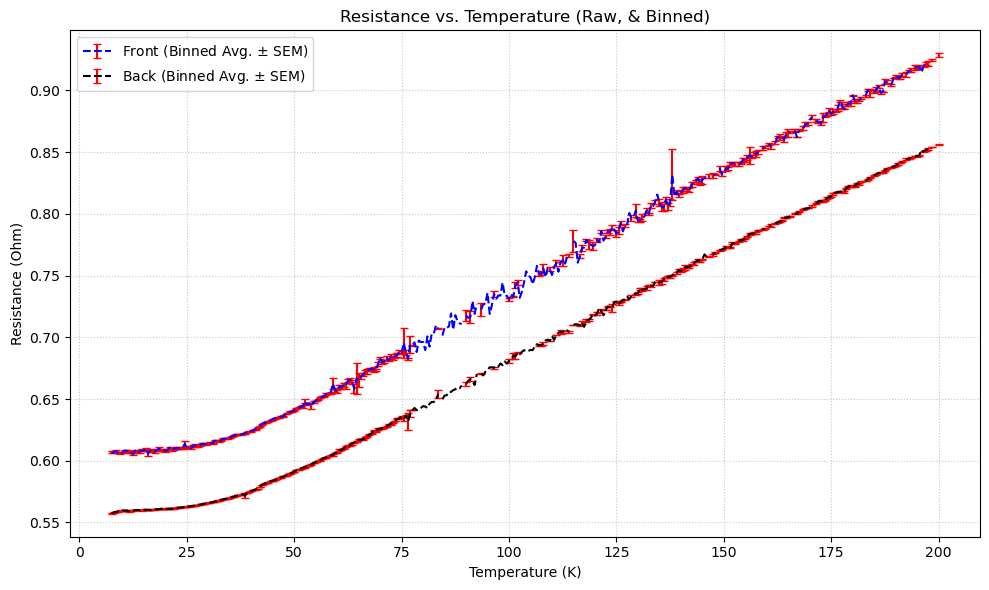

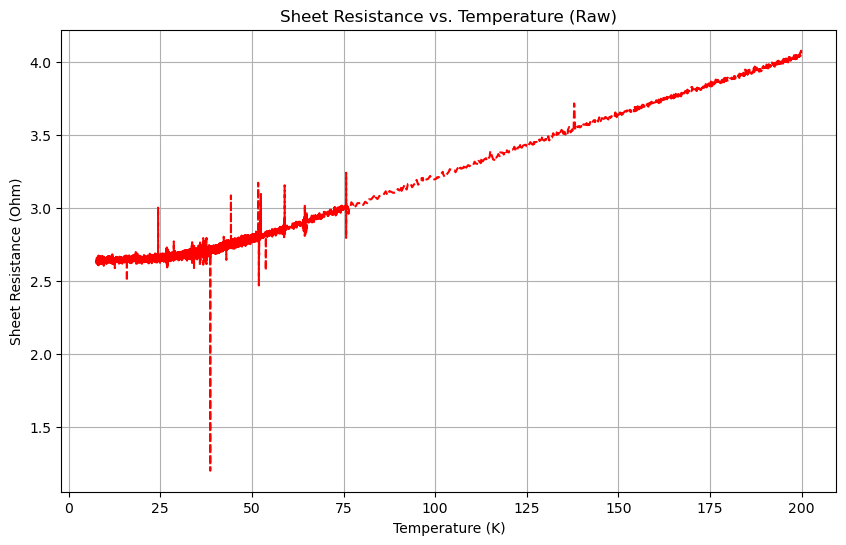

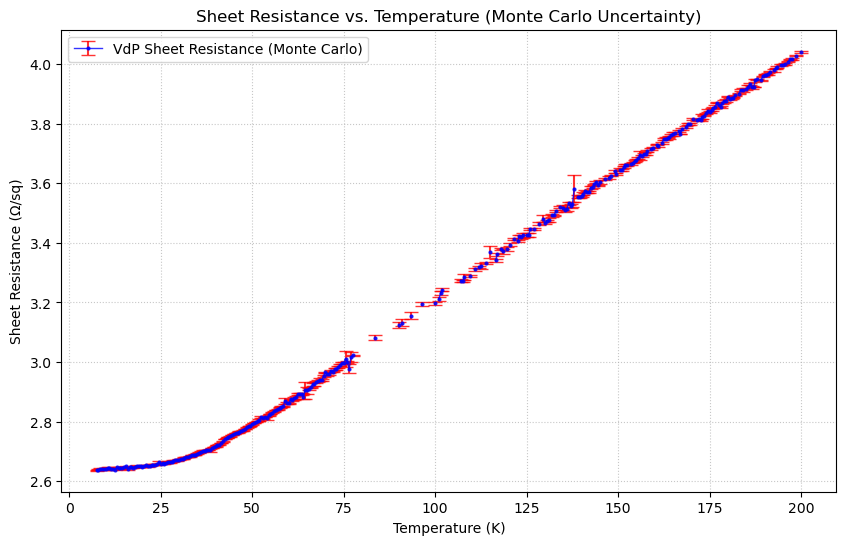

In [ ]:
file_path = "DataSets/heating_8_to_296.dat"
df = pd.read_csv(file_path, sep=r'\s+', header=None, skipinitialspace=True)
df = df.dropna()

# front_temp (Column 6 -> index 5)
# front_temp_fluct (Column 7 -> index 6)
# front_R (Column 8 -> index 7)
# back_temp (Column 17 -> index 16)
# back_temp_fluct (Column 18 -> index 17)
# back_R (Column 19 -> index 18)

front_temp_raw = df.iloc[:, 5].astype(float)
front_temp_fluct_raw = df.iloc[:, 6].astype(float)
front_R = df.iloc[:, 7].astype(float)

back_temp_raw = df.iloc[:, 16].astype(float)
back_temp_fluct_raw = df.iloc[:, 17].astype(float)
back_R = df.iloc[:, 18].astype(float)


# # ---------------------------------------------
# # Mask Creation for filtering
intra_cutoff = 30e-3
inter_cutoff = 30e-3
sel_mask = (
    (front_temp_raw > 7.6) & (back_temp_raw > 7.6) & 
    (front_temp_raw < 200) & (back_temp_raw < 200) & 
    (front_temp_fluct_raw <= intra_cutoff) & (back_temp_fluct_raw <= intra_cutoff) &
    (abs(front_temp_raw - back_temp_raw) <= inter_cutoff))

Tf = front_temp_raw[sel_mask].values
Rf = front_R[sel_mask].values
Tb = back_temp_raw[sel_mask].values
Rb = back_R[sel_mask].values


# # ---------------------------------------------
# # Binning the data
sample_T = np.arange(7.5, 200.5, 0.5) 
Ns = len(sample_T)
binned_Rf = np.zeros(Ns)
binned_Rb = np.zeros(Ns)
binned_Rf_sem = np.zeros(Ns)
binned_Rb_sem = np.zeros(Ns)

jf = 0 
jb = 0

for i in range(Ns):
    lim = sample_T[i] + 0.25

    # Front
    vals_f_in_bin = []
    while jf < len(Rf) and Tf[jf] < lim:
        vals_f_in_bin.append(Rf[jf])
        jf += 1
    
    if len(vals_f_in_bin) > 0:
        binned_Rf[i] = np.mean(vals_f_in_bin)
        binned_Rf_sem[i] = np.std(vals_f_in_bin, ddof=1) / np.sqrt(len(vals_f_in_bin)) if len(vals_f_in_bin) > 1 else np.nan
    else:
        binned_Rf[i] = np.nan
        binned_Rf_sem[i] = np.nan


    # Back
    vals_b_in_bin = []
    while jb < len(Rb) and Tb[jb] < lim:
        vals_b_in_bin.append(Rb[jb])
        jb += 1

    if len(vals_b_in_bin) > 0:
        binned_Rb[i] = np.mean(vals_b_in_bin)
        binned_Rb_sem[i] = np.std(vals_b_in_bin, ddof=1) / np.sqrt(len(vals_b_in_bin)) if len(vals_b_in_bin) > 1 else np.nan
    else:
        binned_Rb[i] = np.nan
        binned_Rb_sem[i] = np.nan

# # ---------------------------------------------
# FILTERED AND BINNED R(T)

plt.figure(figsize=(10, 6))
#plt.scatter(Tf, Rf, s=10, label="Front (Filtered Raw)", alpha=0.6)
plt.errorbar(sample_T, binned_Rf, yerr=binned_Rf_sem, fmt='--', color='blue', ecolor='red', capsize=3, label="Front (Binned Avg. $\pm$ SEM)")
plt.errorbar(sample_T, binned_Rb, yerr=binned_Rb_sem, fmt='--', color='black', ecolor='red', capsize=3, label="Back (Binned Avg. $\pm$ SEM)")
#plt.scatter(Tb, Rb, s=10, label="Back (Filtered Raw)", alpha=0.6)
plt.xlabel("Temperature (K)")
plt.ylabel("Resistance (Ohm)")
plt.title("Resistance vs. Temperature (Filtered & Binned)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# # ---------------------------------------------
# VDP FILTERED DATA
Rs_raw = np.zeros(len(Rf))
i = 0
while i < len(Rf):
    Rs_raw[i] = calculate_sheet_resistance_vdp(Rf[i], Rb[i])
    i += 1

T_avg = (Tf + Tb) / 2

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(T_avg, Rs_raw, linestyle='--', color='red', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature (Raw)")

# # ---------------------------------------------
# VDP FILTERED & BINNED DATA +- MC
clean_Rs_mc = np.zeros(Ns)
clean_Rs_std_mc = np.zeros(Ns)

for i in range(Ns):
    if not (np.isnan(binned_Rf[i]) or np.isnan(binned_Rb[i])):
        Rs_mean, Rs_std, Rs_sem = propagate_vdp_uncertainty_mc(
            binned_Rf[i], binned_Rf_sem[i], binned_Rb[i], binned_Rb_sem[i]
        )
        clean_Rs_mc[i] = Rs_mean
        clean_Rs_std_mc[i] = Rs_std
    else:
        clean_Rs_mc[i] = np.nan
        clean_Rs_std_mc[i] = np.nan

plt.figure(figsize=(10, 6))
plt.errorbar(sample_T, clean_Rs_mc, yerr=clean_Rs_std_mc, fmt='o-', 
             capsize=5, markersize=2, linewidth=1, elinewidth=1.5,         
             label='VdP Sheet Resistance (Monte Carlo)', color='blue', ecolor='red', alpha=0.8)   
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ω/sq)")
plt.title("Sheet Resistance vs. Temperature (Monte Carlo Uncertainty)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

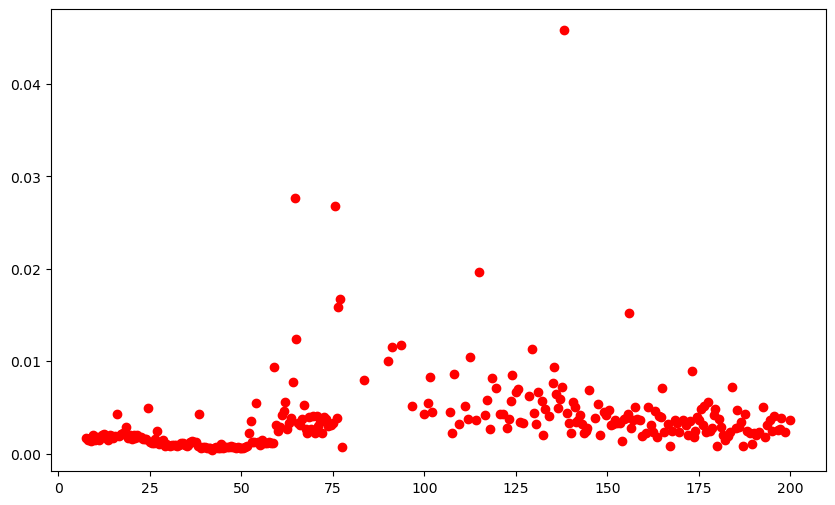

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(sample_T,  clean_Rs_std_mc, 'o', color = 'red')

In [ ]:
print("\nFinal Results Summary:")
print("Temperature (K) | Rs (Ω/sq) | ± Uncertainty (Ω/sq)")
print("-" * 70)
for i in range(0, Ns, 5):
    if not np.isnan(clean_Rs_mc[i]):
        print(f"{sample_T[i]:11.2f} |    {clean_Rs_mc[i]:6.6f} | {clean_Rs_std_mc[i]:13.6f}")


Final Results Summary:
Temperature (K) | Rs (Ω/sq) | ± Uncertainty (Ω/sq) (%)
----------------------------------------------------------------------
       7.50 |    2.636601 |      0.001756
      10.00 |    2.641589 |      0.001416
      12.50 |    2.637925 |      0.002084
      15.00 |    2.646490 |      0.001694
      17.50 |    2.645282 |      0.002191
      20.00 |    2.647737 |      0.001612
      22.50 |    2.654298 |      0.001806
      25.00 |    2.658585 |      0.001227
      27.50 |    2.662975 |      0.001006
      30.00 |    2.671798 |      0.000989
      32.50 |    2.680597 |      0.000812
      35.00 |    2.692118 |      0.000803
      37.50 |    2.703446 |      0.001197
      40.00 |    2.716380 |      0.000686
      42.50 |    2.740474 |      0.000631
      45.00 |    2.757357 |      0.000573
      47.50 |    2.770579 |      0.000681
      50.00 |    2.790443 |      0.000588
      52.50 |    2.814555 |      0.003511
      55.00 |    2.824786 |      0.000883
      57.5

## $\rho_0$ , $\rho_{300}$


### Using Binned data

clean_Rf , clean_Rb , sample_T, clean_Rs_mc 

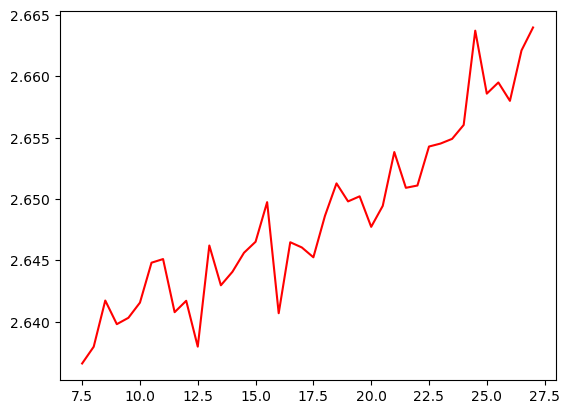

In [89]:
n_points = 40
subset_sample_T = sample_T[0:n_points]
subset_clean_Rs_mc = clean_Rs_mc[0:n_points]
subset_clean_Rs_std_mc = clean_Rs_std_mc[0:n_points]

plt.plot(subset_sample_T, subset_clean_Rs_mc, '-', color='red')

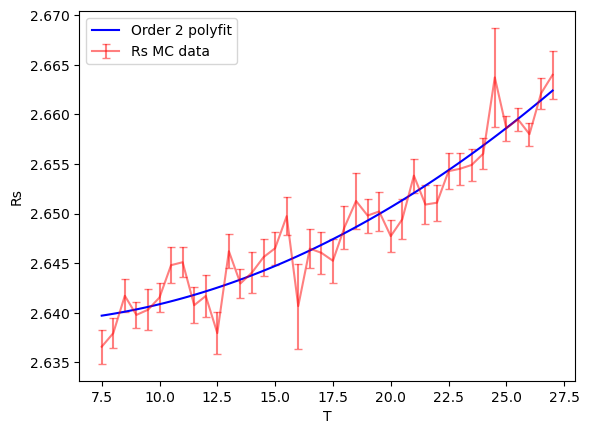

In [90]:
weights = 1 / subset_clean_Rs_std_mc**2

coeffs = np.polyfit(subset_sample_T, subset_clean_Rs_mc, deg=2)
a, b, c = coeffs

T_polyfit = np.linspace(min(subset_sample_T), max(subset_sample_T), 100)
Rs_polyfit_quad = a * T_polyfit**2 + b*T_polyfit + c

plt.errorbar(subset_sample_T, subset_clean_Rs_mc,yerr=subset_clean_Rs_std_mc, color = 'red', label = 'Rs MC data', alpha = 0.5, capsize = 3)
plt.plot(T_polyfit, Rs_polyfit_quad, '-', color = 'blue', label = 'Order 2 polyfit')
plt.xlabel('T')
plt.ylabel('Rs')
plt.legend()
plt.show()

In [91]:
# Calculate R^2 for quadratic fit
ss_res = np.sum((subset_clean_Rs_mc - np.poly1d(coeffs)(subset_sample_T)) ** 2)  # Residual sum of squares
ss_tot = np.sum((subset_clean_Rs_mc - np.mean(subset_clean_Rs_mc)) ** 2)  # Total sum of squares

r_squared_quad = 1 - (ss_res / ss_tot)

print(r_squared_quad)

0.8973426175306561


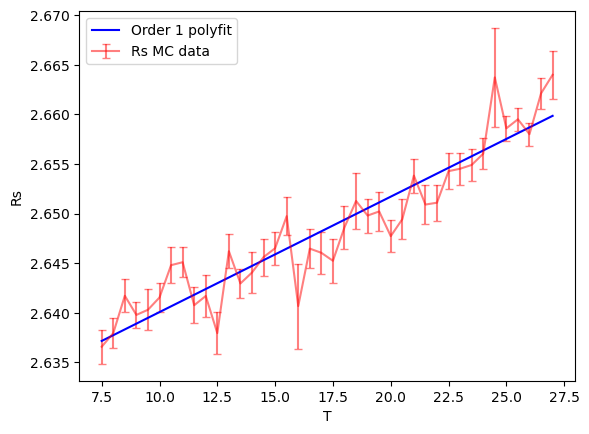

In [92]:
coeffs_lin = np.polyfit(subset_sample_T, subset_clean_Rs_mc, deg=1)
a, b = coeffs_lin

Rs_polyfit_lin = a * T_polyfit + b

plt.errorbar(subset_sample_T, subset_clean_Rs_mc,yerr=subset_clean_Rs_std_mc, color = 'red', label = 'Rs MC data', alpha = 0.5, capsize = 3)
plt.plot(T_polyfit, Rs_polyfit_lin, '-', color = 'blue', label = 'Order 1 polyfit')
plt.xlabel('T')
plt.ylabel('Rs')
plt.legend()
plt.show()

Functions to compute meanigful parameters to evaluate the quality of the fit


In [93]:
def reduced_chi_squared(y_obs, y_model, y_err, num_params):
    """
    Compute the reduced chi-squared statistic.

    Parameters:
    -----------
    y_obs : array_like
        Observed y-values (data)
    y_model : array_like
        Predicted y-values from your model
    y_err : array_like
        Uncertainties (errors) on the observed y-values
    num_params : int
        Number of fitted parameters in the model

    Returns:
    --------
    float
        Reduced chi-squared
    """
    residuals = (y_obs - y_model) / y_err
    chi2 = np.sum(residuals**2)
    dof = len(y_obs) - num_params
    return chi2 / dof


def r_squared(y_obs, y_model):
    """
    Compute the coefficient of determination R².

    Parameters:
    -----------
    y_obs : array_like
        Observed y-values (data)
    y_model : array_like
        Predicted y-values from the model

    Returns:
    --------
    float
        R² value (coefficient of determination)
    """
    ss_res = np.sum((y_obs - y_model) ** 2)              # residual sum of squares
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)       # total sum of squares
    return 1 - (ss_res / ss_tot)


In [94]:
#LINEAR FIT
r_squared_lin = r_squared(subset_clean_Rs_mc, np.poly1d(coeffs_lin)(subset_sample_T))
reduced_chi_lin = reduced_chi_squared(subset_clean_Rs_mc, np.poly1d(coeffs_lin)(subset_sample_T), subset_clean_Rs_std_mc, num_params=2)

print(reduced_chi_lin)
print(r_squared_lin)

1.605370255179895
0.8682535093854771


In [95]:
r_squared_quad = r_squared(subset_clean_Rs_mc, np.poly1d(coeffs)(subset_sample_T))
reduced_chi_quad = reduced_chi_squared(subset_clean_Rs_mc, np.poly1d(coeffs)(subset_sample_T), subset_clean_Rs_std_mc, num_params=3)

print(reduced_chi_quad)
print(r_squared_quad)

1.3892894677663457
0.8973426175306561


## fix $n$ by generating the $ln(\rho-\rho_0)$ vs $ln(T)$ fit

In [97]:
#use the quadratic fit to define Rs0
Rs0 = np.poly1d(coeffs)(subset_sample_T)[0]
rr0 = clean_Rs_mc - Rs0

C:\Users\fzana\AppData\Local\Temp\ipykernel_22364\1708059989.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(sample_T) ,np.log(rr0))


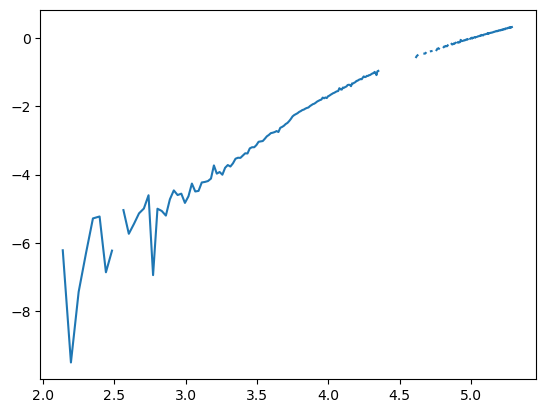

In [99]:
plt.plot(np.log(sample_T) ,np.log(rr0))

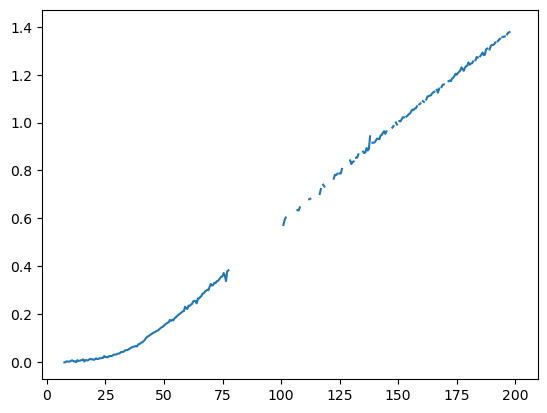

In [102]:
plt.plot(sample_T,rr0)

# **DRAMMA**